### Model

A 2 layer transformer with 2 head in each attention layer was used. Here, the model performed best with a dropout of 0.3 and a learning rate of 1e-12. Early stopping was employed during training.

### Results

The highest accuracy achieved is roughly 62%. Based on the training and validation plots, the model seems to be have the ability to learn more but its accuracy does not go above 61% despite changing hyperparameters such as number of layers, heads, learning rate, etc. This could be due to issues with the dataset such as the data being improperly labelled. This is briefly explained in the article [Low accuracy of Transformer model for 1D Data](https://stackoverflow.com/questions/67755365/low-accuracy-of-transformer-model-for-1d-data).

Resources Used:

*   [Writing a Transformer Classifier in PyTorch](https://n8henrie.com/2021/08/writing-a-transformer-classifier-in-pytorch/)
*   [LANGUAGE MODELING WITH NN.TRANSFORMER AND TORCHTEXT](https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model)



## Imports

In [1]:
# !pip install torchtext==0.6.0

In [2]:
import math
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, TabularDataset
from torchtext.vocab import Vectors
import torch.nn.functional as F
from torch import nn, optim

warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definitions

In [3]:
batch_size = 16
vocab_size = 3097

PATH = "/content/drive/MyDrive/Class Stuff/Fall23/NLP/Final Project/Data"
train_path = os.path.join(PATH,"train.csv")
val_path = os.path.join(PATH,"val.csv")
test_path = os.path.join(PATH,"test.csv")

## Data Loaders

In [4]:
TEXT = Field(sequential=True, lower=True, include_lengths=False, batch_first=True)
LABEL = Field(sequential=False, use_vocab=False)

fields = [('sentence', TEXT), ('label', LABEL)]

In [5]:
train_data = TabularDataset(
    path=train_path,
    format="csv",
    fields=fields,
    skip_header=True
)

val_data = TabularDataset(
    path=val_path,
    format="csv",
    fields=fields,
    skip_header=True
)

test_data = TabularDataset(
    path=test_path,
    format="csv",
    fields=fields,
    skip_header=True
)

In [6]:
glove_vectors = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=50_000)

In [7]:
TEXT.build_vocab(train_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(train_data)

TEXT.build_vocab(val_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(val_data)

TEXT.build_vocab(test_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(test_data)

In [8]:
train_iter = torchtext.data.BucketIterator(
    dataset=train_data,
    batch_size=batch_size
)

val_iter = torchtext.data.BucketIterator(
    dataset=val_data,
    batch_size=batch_size
)

test_iter = torchtext.data.BucketIterator(
    dataset=test_data,
    batch_size=batch_size
)

In [9]:
N_train = 0
N_val = 0
N_test = 0
for x,y in train_iter:
  N_train+=len(x[0])
for x,y in val_iter:
    N_val+=len(x[0])
for x,y in test_iter:
    N_test+=len(x[0])

## Model Definition

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, vocab_size=3097, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

In [11]:
class Net(nn.Module):

    def __init__(
        self,
        embeddings,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1,
    ):

        super().__init__()

        vocab_size, d_model = embeddings.size()

        self.emb = nn.Embedding.from_pretrained(embeddings, freeze=False)

        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(d_model, 2)
        self.d_model = d_model

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [12]:
n_heads =2
num_layers = 2

In [13]:
model = Net(
    TEXT.vocab.vectors,
    nhead=n_heads,
    dim_feedforward=50,
    num_layers=num_layers,
    dropout=0.3,
    classifier_dropout=0.3,
).to(device)

In [14]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters in the transformer model: {params}")

Number of parameters in the transformer model: 72452


## Plot Definitions

In [15]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy,last_epoch):

    plt.figure(figsize=(5, 3))
    plt.plot(training_loss[:last_epoch],label='Training',color='g')
    plt.plot(validation_loss[:last_epoch],label='Validation',color='b')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    print('Final Training Loss:  ',np.around(training_loss[last_epoch],6))
    print('Final Validation Loss:',np.around(validation_loss[last_epoch],6))

    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy[:last_epoch],label='Training',color='g')
    plt.plot(validation_accuracy[:last_epoch],label='Validation',color='b')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    print('Final Training Accuracy:  ',np.around(training_accuracy[last_epoch],6))
    print('Final Validation Accuracy:',np.around(validation_accuracy[last_epoch],6))
    print()

    print("Test Accuracy:", np.around(test_accuracy.item(),4))

    print()

## Training

In [16]:
epochs = 400
lr = 1e-12

best_val_score = float("-inf")
count_no_improvements = 0
earlyStop = 80
last_epoch = 0

WEIGHTS_PATH = "/content/drive/MyDrive/Class Stuff/Fall23/NLP/Final Project/Weights/transformer.pt"

In [17]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

torch.manual_seed(10)

training_losses = np.zeros(epochs)
val_losses      = np.zeros(epochs)

training_accuracy = np.zeros(epochs)
val_accuracy      = np.zeros(epochs)

for epoch in tqdm(range(epochs)):
    print(f"{epoch=}")
    epoch_loss = 0
    epoch_correct = 0
    epoch_count = 0
    for idx, batch in enumerate(iter(train_iter)):
        predictions = model(batch.sentence.to(device))
        labels = F.one_hot(batch.label, num_classes=2).float().to(device)

        loss = criterion(predictions, labels)

        correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

        epoch_correct += correct.sum().item()

        epoch_loss += loss.item()

        training_losses[epoch]   = epoch_loss/N_train
        training_accuracy[epoch] = epoch_correct/N_train

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        optimizer.step()

    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_correct = 0

        for idx, batch in enumerate(iter(val_iter)):
            predictions = model(batch.sentence.to(device))
            labels = F.one_hot(batch.label, num_classes=2).float().to(device)
            test_loss = criterion(predictions, labels)

            correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

            val_epoch_correct += correct.sum().item()
            val_epoch_loss += loss.item()

            val_losses[epoch]   = val_epoch_loss/N_val
            val_accuracy[epoch] = val_epoch_correct/N_val
        if val_accuracy[epoch]>best_val_score:
          best_val_score = val_accuracy[epoch]
          torch.save(model.state_dict(), WEIGHTS_PATH)
          count_no_improvements = 0
        else:
          count_no_improvements+=1
          if count_no_improvements>earlyStop:
            last_epoch = epoch
            break
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {training_losses[epoch]}, Train Accuracy: {training_accuracy[epoch]}")
    print(f"Validation Loss: {val_losses[epoch]}, Validation Accuracy: {val_accuracy[epoch]}")
    last_epoch = epoch

  0%|          | 0/400 [00:00<?, ?it/s]

epoch=0


  0%|          | 1/400 [00:02<14:56,  2.25s/it]

Epoch: 0
Train Loss: 0.04313805731137593, Train Accuracy: 0.608
Validation Loss: 0.04414594557977492, Validation Accuracy: 0.6236559139784946
epoch=1


  0%|          | 2/400 [00:05<17:43,  2.67s/it]

Epoch: 1
Train Loss: 0.04327613218625387, Train Accuracy: 0.6093333333333333
Validation Loss: 0.045356804324734594, Validation Accuracy: 0.6129032258064516
epoch=2


  1%|          | 3/400 [00:08<18:22,  2.78s/it]

Epoch: 2
Train Loss: 0.043110889037450154, Train Accuracy: 0.6026666666666667
Validation Loss: 0.044007766631341746, Validation Accuracy: 0.6021505376344086
epoch=3


  1%|          | 4/400 [00:09<14:47,  2.24s/it]

Epoch: 3
Train Loss: 0.04309804042180379, Train Accuracy: 0.6133333333333333
Validation Loss: 0.0430884591994747, Validation Accuracy: 0.6236559139784946
epoch=4


  1%|▏         | 5/400 [00:11<13:36,  2.07s/it]

Epoch: 4
Train Loss: 0.04322836335500081, Train Accuracy: 0.6013333333333334
Validation Loss: 0.04471571599283526, Validation Accuracy: 0.6236559139784946
epoch=5


  2%|▏         | 6/400 [00:12<12:14,  1.86s/it]

Epoch: 5
Train Loss: 0.04317868630091349, Train Accuracy: 0.608
Validation Loss: 0.045412821154440605, Validation Accuracy: 0.6559139784946236
epoch=6


  2%|▏         | 7/400 [00:14<12:44,  1.95s/it]

Epoch: 6
Train Loss: 0.043230342944463096, Train Accuracy: 0.6093333333333333
Validation Loss: 0.04385711685303719, Validation Accuracy: 0.5806451612903226
epoch=7


  2%|▏         | 8/400 [00:16<11:04,  1.69s/it]

Epoch: 7
Train Loss: 0.043224369605382285, Train Accuracy: 0.6106666666666667
Validation Loss: 0.04601923881038543, Validation Accuracy: 0.6021505376344086
epoch=8


  2%|▏         | 9/400 [00:16<09:03,  1.39s/it]

Epoch: 8
Train Loss: 0.04320982774098714, Train Accuracy: 0.6093333333333333
Validation Loss: 0.04472614872840143, Validation Accuracy: 0.6344086021505376
epoch=9


  2%|▎         | 10/400 [00:17<07:40,  1.18s/it]

Epoch: 9
Train Loss: 0.04323234502474467, Train Accuracy: 0.6053333333333333
Validation Loss: 0.043929599946545016, Validation Accuracy: 0.6129032258064516
epoch=10


  3%|▎         | 11/400 [00:18<07:08,  1.10s/it]

Epoch: 10
Train Loss: 0.04327004432678223, Train Accuracy: 0.608
Validation Loss: 0.044575645077613094, Validation Accuracy: 0.6451612903225806
epoch=11


  3%|▎         | 12/400 [00:19<06:55,  1.07s/it]

Epoch: 11
Train Loss: 0.04326103734970093, Train Accuracy: 0.596
Validation Loss: 0.042714895740632086, Validation Accuracy: 0.6236559139784946
epoch=12


  3%|▎         | 13/400 [00:20<06:47,  1.05s/it]

Epoch: 12
Train Loss: 0.0432095775604248, Train Accuracy: 0.6013333333333334
Validation Loss: 0.04452554641231414, Validation Accuracy: 0.6236559139784946
epoch=13


  4%|▎         | 14/400 [00:21<06:40,  1.04s/it]

Epoch: 13
Train Loss: 0.0431642587184906, Train Accuracy: 0.608
Validation Loss: 0.04414013893373551, Validation Accuracy: 0.6344086021505376
epoch=14


  4%|▍         | 15/400 [00:22<06:33,  1.02s/it]

Epoch: 14
Train Loss: 0.04310167694091797, Train Accuracy: 0.6106666666666667
Validation Loss: 0.04437533117109729, Validation Accuracy: 0.6129032258064516
epoch=15


  4%|▍         | 16/400 [00:23<06:33,  1.02s/it]

Epoch: 15
Train Loss: 0.04332448355356852, Train Accuracy: 0.6026666666666667
Validation Loss: 0.045343010656295285, Validation Accuracy: 0.6129032258064516
epoch=16


  4%|▍         | 17/400 [00:24<06:00,  1.06it/s]

Epoch: 16
Train Loss: 0.04325867462158203, Train Accuracy: 0.6
Validation Loss: 0.044532079850473714, Validation Accuracy: 0.6451612903225806
epoch=17


  4%|▍         | 18/400 [00:24<05:31,  1.15it/s]

Epoch: 17
Train Loss: 0.04326836856206258, Train Accuracy: 0.6093333333333333
Validation Loss: 0.04549495250948014, Validation Accuracy: 0.5913978494623656
epoch=18


  5%|▍         | 19/400 [00:25<05:12,  1.22it/s]

Epoch: 18
Train Loss: 0.043300068775812786, Train Accuracy: 0.6
Validation Loss: 0.044697696162808324, Validation Accuracy: 0.5913978494623656
epoch=19


  5%|▌         | 20/400 [00:26<04:57,  1.28it/s]

Epoch: 19
Train Loss: 0.04313591980934143, Train Accuracy: 0.608
Validation Loss: 0.04628031484542355, Validation Accuracy: 0.6236559139784946
epoch=20


  5%|▌         | 21/400 [00:26<04:50,  1.30it/s]

Epoch: 20
Train Loss: 0.04326600003242493, Train Accuracy: 0.6013333333333334
Validation Loss: 0.0444292099245133, Validation Accuracy: 0.5913978494623656
epoch=21


  6%|▌         | 22/400 [00:27<04:42,  1.34it/s]

Epoch: 21
Train Loss: 0.04311531694730123, Train Accuracy: 0.6066666666666667
Validation Loss: 0.04365648377326227, Validation Accuracy: 0.6129032258064516
epoch=22


  6%|▌         | 23/400 [00:28<04:38,  1.35it/s]

Epoch: 22
Train Loss: 0.04314693601926168, Train Accuracy: 0.6106666666666667
Validation Loss: 0.04513594027488462, Validation Accuracy: 0.6236559139784946
epoch=23


  6%|▌         | 24/400 [00:29<04:35,  1.36it/s]

Epoch: 23
Train Loss: 0.043231112718582154, Train Accuracy: 0.6013333333333334
Validation Loss: 0.04512511530230122, Validation Accuracy: 0.6129032258064516
epoch=24


  6%|▋         | 25/400 [00:29<04:33,  1.37it/s]

Epoch: 24
Train Loss: 0.04313822937011719, Train Accuracy: 0.6053333333333333
Validation Loss: 0.04275455782490392, Validation Accuracy: 0.6344086021505376
epoch=25


  6%|▋         | 26/400 [00:30<04:34,  1.36it/s]

Epoch: 25
Train Loss: 0.04320717255274455, Train Accuracy: 0.6013333333333334
Validation Loss: 0.04363306491605697, Validation Accuracy: 0.6021505376344086
epoch=26


  7%|▋         | 27/400 [00:31<04:34,  1.36it/s]

Epoch: 26
Train Loss: 0.043300266186396284, Train Accuracy: 0.604
Validation Loss: 0.04334647809305499, Validation Accuracy: 0.5913978494623656
epoch=27


  7%|▋         | 28/400 [00:32<04:33,  1.36it/s]

Epoch: 27
Train Loss: 0.043177269538243614, Train Accuracy: 0.6026666666666667
Validation Loss: 0.044214302493679906, Validation Accuracy: 0.6021505376344086
epoch=28


  7%|▋         | 29/400 [00:32<04:32,  1.36it/s]

Epoch: 28
Train Loss: 0.04323895525932312, Train Accuracy: 0.6026666666666667
Validation Loss: 0.044218713237393285, Validation Accuracy: 0.6021505376344086
epoch=29


  8%|▊         | 30/400 [00:33<04:34,  1.35it/s]

Epoch: 29
Train Loss: 0.043272650321324664, Train Accuracy: 0.596
Validation Loss: 0.04480410775830669, Validation Accuracy: 0.6129032258064516
epoch=30


  8%|▊         | 31/400 [00:34<05:09,  1.19it/s]

Epoch: 30
Train Loss: 0.04315396277109782, Train Accuracy: 0.5986666666666667
Validation Loss: 0.044434566651621175, Validation Accuracy: 0.6021505376344086
epoch=31


  8%|▊         | 32/400 [00:35<05:29,  1.12it/s]

Epoch: 31
Train Loss: 0.04312654145558675, Train Accuracy: 0.6146666666666667
Validation Loss: 0.044931992407768004, Validation Accuracy: 0.6451612903225806
epoch=32


  8%|▊         | 33/400 [00:36<05:44,  1.06it/s]

Epoch: 32
Train Loss: 0.04322678446769714, Train Accuracy: 0.6146666666666667
Validation Loss: 0.04294107421751945, Validation Accuracy: 0.6129032258064516
epoch=33


  8%|▊         | 34/400 [00:37<05:54,  1.03it/s]

Epoch: 33
Train Loss: 0.043229602098464964, Train Accuracy: 0.604
Validation Loss: 0.04451264873627694, Validation Accuracy: 0.6344086021505376
epoch=34


  9%|▉         | 35/400 [00:38<06:00,  1.01it/s]

Epoch: 34
Train Loss: 0.04309749420483907, Train Accuracy: 0.608
Validation Loss: 0.0439417669850011, Validation Accuracy: 0.6559139784946236
epoch=35


  9%|▉         | 36/400 [00:39<05:47,  1.05it/s]

Epoch: 35
Train Loss: 0.043339109977086385, Train Accuracy: 0.592
Validation Loss: 0.044702422234319875, Validation Accuracy: 0.6236559139784946
epoch=36


  9%|▉         | 37/400 [00:40<05:22,  1.13it/s]

Epoch: 36
Train Loss: 0.04333960509300232, Train Accuracy: 0.6026666666666667
Validation Loss: 0.043287923259119836, Validation Accuracy: 0.6021505376344086
epoch=37


 10%|▉         | 38/400 [00:41<05:03,  1.19it/s]

Epoch: 37
Train Loss: 0.04318934830029805, Train Accuracy: 0.6066666666666667
Validation Loss: 0.04503678121874409, Validation Accuracy: 0.6236559139784946
epoch=38


 10%|▉         | 39/400 [00:41<04:51,  1.24it/s]

Epoch: 38
Train Loss: 0.043167094628016156, Train Accuracy: 0.6013333333333334
Validation Loss: 0.04424762725830078, Validation Accuracy: 0.6236559139784946
epoch=39


 10%|█         | 40/400 [00:42<04:41,  1.28it/s]

Epoch: 39
Train Loss: 0.04313687062263489, Train Accuracy: 0.6013333333333334
Validation Loss: 0.04486577357015302, Validation Accuracy: 0.6451612903225806
epoch=40


 10%|█         | 41/400 [00:43<04:35,  1.30it/s]

Epoch: 40
Train Loss: 0.0432254212697347, Train Accuracy: 0.6013333333333334
Validation Loss: 0.04633851205149005, Validation Accuracy: 0.6129032258064516
epoch=41


 10%|█         | 42/400 [00:44<04:32,  1.31it/s]

Epoch: 41
Train Loss: 0.043142176548639936, Train Accuracy: 0.6133333333333333
Validation Loss: 0.044796251481579195, Validation Accuracy: 0.6236559139784946
epoch=42


 11%|█         | 43/400 [00:44<04:28,  1.33it/s]

Epoch: 42
Train Loss: 0.04330629777908325, Train Accuracy: 0.6093333333333333
Validation Loss: 0.044278944692304055, Validation Accuracy: 0.6344086021505376
epoch=43


 11%|█         | 44/400 [00:45<04:23,  1.35it/s]

Epoch: 43
Train Loss: 0.04320087718963623, Train Accuracy: 0.608
Validation Loss: 0.04496637851961197, Validation Accuracy: 0.6236559139784946
epoch=44


 11%|█▏        | 45/400 [00:46<04:20,  1.36it/s]

Epoch: 44
Train Loss: 0.04314564561843872, Train Accuracy: 0.6066666666666667
Validation Loss: 0.044302832695745656, Validation Accuracy: 0.6236559139784946
epoch=45


 12%|█▏        | 46/400 [00:46<04:19,  1.37it/s]

Epoch: 45
Train Loss: 0.04310792549451192, Train Accuracy: 0.616
Validation Loss: 0.04393307624324676, Validation Accuracy: 0.6236559139784946
epoch=46


 12%|█▏        | 47/400 [00:47<04:18,  1.36it/s]

Epoch: 46
Train Loss: 0.04326291163762411, Train Accuracy: 0.6026666666666667
Validation Loss: 0.04324936097668063, Validation Accuracy: 0.6129032258064516
epoch=47


 12%|█▏        | 48/400 [00:48<04:19,  1.36it/s]

Epoch: 47
Train Loss: 0.04324545629819234, Train Accuracy: 0.6173333333333333
Validation Loss: 0.04524180581492762, Validation Accuracy: 0.6021505376344086
epoch=48


 12%|█▏        | 49/400 [00:49<04:16,  1.37it/s]

Epoch: 48
Train Loss: 0.043200129667917885, Train Accuracy: 0.5986666666666667
Validation Loss: 0.0449337690107284, Validation Accuracy: 0.6344086021505376
epoch=49


 12%|█▎        | 50/400 [00:50<04:40,  1.25it/s]

Epoch: 49
Train Loss: 0.04323424474398295, Train Accuracy: 0.6013333333333334
Validation Loss: 0.04516157027213804, Validation Accuracy: 0.6021505376344086
epoch=50


 13%|█▎        | 51/400 [00:51<05:01,  1.16it/s]

Epoch: 50
Train Loss: 0.04312847820917765, Train Accuracy: 0.608
Validation Loss: 0.04546078174344955, Validation Accuracy: 0.6344086021505376
epoch=51


 13%|█▎        | 52/400 [00:52<05:19,  1.09it/s]

Epoch: 51
Train Loss: 0.04318963837623596, Train Accuracy: 0.612
Validation Loss: 0.043663620948791504, Validation Accuracy: 0.6236559139784946
epoch=52


 13%|█▎        | 53/400 [00:53<05:29,  1.05it/s]

Epoch: 52
Train Loss: 0.04316839059193929, Train Accuracy: 0.6053333333333333
Validation Loss: 0.04525488422762963, Validation Accuracy: 0.6236559139784946
epoch=53


 14%|█▎        | 54/400 [00:54<05:34,  1.03it/s]

Epoch: 53
Train Loss: 0.043206737359364825, Train Accuracy: 0.6066666666666667
Validation Loss: 0.04540108480761128, Validation Accuracy: 0.6344086021505376
epoch=54


 14%|█▍        | 55/400 [00:55<05:33,  1.03it/s]

Epoch: 54
Train Loss: 0.043201695919036866, Train Accuracy: 0.6186666666666667
Validation Loss: 0.044573991529403195, Validation Accuracy: 0.5698924731182796
epoch=55


 14%|█▍        | 56/400 [00:55<05:08,  1.11it/s]

Epoch: 55
Train Loss: 0.04317999792098999, Train Accuracy: 0.604
Validation Loss: 0.04424201673076999, Validation Accuracy: 0.6021505376344086
epoch=56


 14%|█▍        | 57/400 [00:56<04:51,  1.18it/s]

Epoch: 56
Train Loss: 0.04306809337933858, Train Accuracy: 0.6106666666666667
Validation Loss: 0.04267151125015751, Validation Accuracy: 0.6451612903225806
epoch=57


 14%|█▍        | 58/400 [00:57<04:36,  1.24it/s]

Epoch: 57
Train Loss: 0.04314813947677612, Train Accuracy: 0.6
Validation Loss: 0.044247135039298766, Validation Accuracy: 0.6559139784946236
epoch=58


 15%|█▍        | 59/400 [00:58<04:27,  1.28it/s]

Epoch: 58
Train Loss: 0.04314120531082153, Train Accuracy: 0.612
Validation Loss: 0.04465455009091285, Validation Accuracy: 0.6451612903225806
epoch=59


 15%|█▌        | 60/400 [00:58<04:20,  1.31it/s]

Epoch: 59
Train Loss: 0.043263853391011554, Train Accuracy: 0.6026666666666667
Validation Loss: 0.04543994319054388, Validation Accuracy: 0.5806451612903226
epoch=60


 15%|█▌        | 61/400 [00:59<04:13,  1.34it/s]

Epoch: 60
Train Loss: 0.04323328971862793, Train Accuracy: 0.6133333333333333
Validation Loss: 0.044965586354655605, Validation Accuracy: 0.5913978494623656
epoch=61


 16%|█▌        | 62/400 [01:00<04:09,  1.36it/s]

Epoch: 61
Train Loss: 0.043160800457000735, Train Accuracy: 0.6013333333333334
Validation Loss: 0.04336061785298009, Validation Accuracy: 0.6129032258064516
epoch=62


 16%|█▌        | 63/400 [01:00<04:07,  1.36it/s]

Epoch: 62
Train Loss: 0.043217766682306924, Train Accuracy: 0.5986666666666667
Validation Loss: 0.04491528772538708, Validation Accuracy: 0.6236559139784946
epoch=63


 16%|█▌        | 64/400 [01:01<04:04,  1.37it/s]

Epoch: 63
Train Loss: 0.04318628334999085, Train Accuracy: 0.6133333333333333
Validation Loss: 0.04302672416933121, Validation Accuracy: 0.6129032258064516
epoch=64


 16%|█▋        | 65/400 [01:02<04:01,  1.39it/s]

Epoch: 64
Train Loss: 0.04310422738393148, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04306721302770799, Validation Accuracy: 0.6344086021505376
epoch=65


 16%|█▋        | 66/400 [01:03<04:01,  1.38it/s]

Epoch: 65
Train Loss: 0.043216304858525595, Train Accuracy: 0.6
Validation Loss: 0.04434985114682105, Validation Accuracy: 0.6236559139784946
epoch=66


 17%|█▋        | 67/400 [01:03<03:59,  1.39it/s]

Epoch: 66
Train Loss: 0.0431923181215922, Train Accuracy: 0.612
Validation Loss: 0.045185231393383395, Validation Accuracy: 0.6344086021505376
epoch=67


 17%|█▋        | 68/400 [01:04<03:57,  1.40it/s]

Epoch: 67
Train Loss: 0.04330668099721273, Train Accuracy: 0.612
Validation Loss: 0.04545238325672765, Validation Accuracy: 0.6344086021505376
epoch=68


 17%|█▋        | 69/400 [01:05<04:09,  1.33it/s]

Epoch: 68
Train Loss: 0.04319550140698751, Train Accuracy: 0.6093333333333333
Validation Loss: 0.04275705737452353, Validation Accuracy: 0.6021505376344086
epoch=69


 18%|█▊        | 70/400 [01:06<04:34,  1.20it/s]

Epoch: 69
Train Loss: 0.043129168510437015, Train Accuracy: 0.6053333333333333
Validation Loss: 0.04521881380388813, Validation Accuracy: 0.6129032258064516
epoch=70


 18%|█▊        | 71/400 [01:07<04:57,  1.11it/s]

Epoch: 70
Train Loss: 0.043171329975128174, Train Accuracy: 0.6133333333333333
Validation Loss: 0.04449526725276824, Validation Accuracy: 0.6129032258064516
epoch=71


 18%|█▊        | 72/400 [01:08<05:06,  1.07it/s]

Epoch: 71
Train Loss: 0.043126486698786416, Train Accuracy: 0.6026666666666667
Validation Loss: 0.04505961172042355, Validation Accuracy: 0.6021505376344086
epoch=72


 18%|█▊        | 73/400 [01:09<05:12,  1.05it/s]

Epoch: 72
Train Loss: 0.04320030164718628, Train Accuracy: 0.6
Validation Loss: 0.04435739978667228, Validation Accuracy: 0.6344086021505376
epoch=73


 18%|█▊        | 74/400 [01:10<05:17,  1.03it/s]

Epoch: 73
Train Loss: 0.043251530488332114, Train Accuracy: 0.5946666666666667
Validation Loss: 0.04439365094707858, Validation Accuracy: 0.6129032258064516
epoch=74


 19%|█▉        | 75/400 [01:11<05:00,  1.08it/s]

Epoch: 74
Train Loss: 0.04315951331456502, Train Accuracy: 0.6173333333333333
Validation Loss: 0.04430150216625583, Validation Accuracy: 0.6236559139784946
epoch=75


 19%|█▉        | 76/400 [01:11<04:38,  1.16it/s]

Epoch: 75
Train Loss: 0.0432694665590922, Train Accuracy: 0.6013333333333334
Validation Loss: 0.04334172894877772, Validation Accuracy: 0.6236559139784946
epoch=76


 19%|█▉        | 77/400 [01:12<04:22,  1.23it/s]

Epoch: 76
Train Loss: 0.04318528469403585, Train Accuracy: 0.5933333333333334
Validation Loss: 0.043628608026812156, Validation Accuracy: 0.5913978494623656
epoch=77


 20%|█▉        | 78/400 [01:13<04:12,  1.28it/s]

Epoch: 77
Train Loss: 0.04316693472862244, Train Accuracy: 0.612
Validation Loss: 0.04435361200763333, Validation Accuracy: 0.6021505376344086
epoch=78


 20%|█▉        | 79/400 [01:14<04:04,  1.31it/s]

Epoch: 78
Train Loss: 0.043064683357874556, Train Accuracy: 0.6186666666666667
Validation Loss: 0.04518805396172308, Validation Accuracy: 0.6129032258064516
epoch=79


 20%|██        | 80/400 [01:14<04:04,  1.31it/s]

Epoch: 79
Train Loss: 0.04310588494936625, Train Accuracy: 0.612
Validation Loss: 0.043380383522279804, Validation Accuracy: 0.6344086021505376
epoch=80


 20%|██        | 81/400 [01:15<04:00,  1.33it/s]

Epoch: 80
Train Loss: 0.04325865968068441, Train Accuracy: 0.592
Validation Loss: 0.04469174338925269, Validation Accuracy: 0.6129032258064516
epoch=81


 20%|██        | 82/400 [01:16<03:57,  1.34it/s]

Epoch: 81
Train Loss: 0.043239451885223386, Train Accuracy: 0.6186666666666667
Validation Loss: 0.045095028415802985, Validation Accuracy: 0.6021505376344086
epoch=82


 21%|██        | 83/400 [01:17<03:55,  1.35it/s]

Epoch: 82
Train Loss: 0.04329781190554301, Train Accuracy: 0.608
Validation Loss: 0.04588595513374575, Validation Accuracy: 0.6129032258064516
epoch=83


 21%|██        | 84/400 [01:17<03:53,  1.35it/s]

Epoch: 83
Train Loss: 0.04318285338083903, Train Accuracy: 0.608
Validation Loss: 0.04417317144332394, Validation Accuracy: 0.6451612903225806
epoch=84


 21%|██▏       | 85/400 [01:18<03:52,  1.35it/s]

Epoch: 84
Train Loss: 0.043229180256525675, Train Accuracy: 0.6053333333333333
Validation Loss: 0.044106160440752586, Validation Accuracy: 0.6236559139784946
epoch=85


 22%|██▏       | 86/400 [01:19<03:50,  1.36it/s]

Epoch: 85
Train Loss: 0.04316137313842774, Train Accuracy: 0.616
Validation Loss: 0.04388095486548639, Validation Accuracy: 0.6344086021505376
epoch=86


 22%|██▏       | 86/400 [01:19<04:52,  1.08it/s]


## Testing

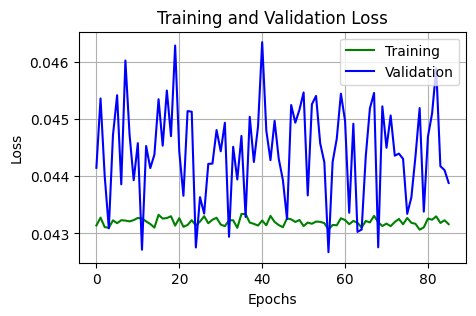

Final Training Loss:   0.043294
Final Validation Loss: 0.014565


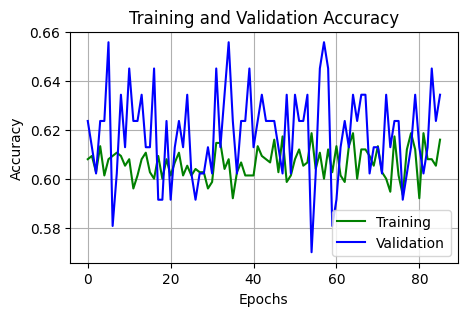

Final Training Accuracy:   0.605333
Final Validation Accuracy: 0.645161

Test Accuracy: 0.625



In [18]:
num_correct_test = 0
evalModel = model
evalModel.load_state_dict(torch.load(WEIGHTS_PATH))
evalModel.eval()

test_loss = 0
test_correct = 0

for idx, batch in enumerate(iter(test_iter)):
  predictions = model(batch.sentence.to(device))
  labels = F.one_hot(batch.label, num_classes=2).float().to(device)
  test_loss = criterion(predictions, labels)

  correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

  test_correct += correct.sum()
  test_loss += loss.item()

  val_losses[epoch]   = test_loss/N_val
  val_accuracy[epoch] = test_correct/N_val

test_accuracy = test_correct / N_test

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy,last_epoch)